In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [18]:
class Residual(nn.Module):
    
    def __init__(self, input_channels, num_channels, use_1x1conv=False,strides=1):
        super().__init__()
        self.conv1 = nn.Conv2d(input_channels, num_channels, kernel_size=3, padding=1, stride=strides)
        self.conv2 = nn.Conv2d(num_channels, num_channels, kernel_size=3, padding=1)
        
        if (use_1x1conv):
            self.conv3 = nn.Conv2d(input_channels, num_channels, kernel_size=1, stride=strides)
        else:
            self.conv3 = None
        
        self.bn1 = nn.BatchNorm2d(num_channels)
        self.bn2 = nn.BatchNorm2d(num_channels)
    
    def forward(self, X):
        
        out = F.relu(self.bn1(self.conv1(X)))
        out = self.bn2(self.conv2(out))
        if(self.conv3):
            X = self.conv3(X)
        out += X
        return F.relu(out)
        
    

In [19]:
blk = Residual(3,3)
X = torch.rand(4,3,6,6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 6, 6])

In [20]:
blk = Residual(3,3,use_1x1conv=True,strides=2)
X = torch.rand(4,3,6,6)
Y = blk(X)
Y.shape

torch.Size([4, 3, 3, 3])

In [21]:
#resent model

b1 = nn.Sequential(nn.Conv2d(1,64,kernel_size=7, stride=2, padding=3),
                   nn.BatchNorm2d(64), nn.ReLU(),
                   nn.MaxPool2d(kernel_size=3, stride=2, padding=1))

In [25]:
def resnet_blk(input_channels, num_channels, num_resnet_blocks,first_block=False ):
    blk = []
    
    for i in range(num_resnet_blocks):
        if i==0 and not first_block:
            blk.append(Residual(input_channels, num_channels, use_1x1conv=True, strides=2))
        else:
            blk.append(Residual(num_channels, num_channels))
    
    return blk

In [26]:
b2 = nn.Sequential(*resnet_blk(64,64,2, first_block=True))
b3 = nn.Sequential(*resnet_blk(64, 128, 2))
b4 = nn.Sequential(*resnet_blk(128,256,2))
b5 = nn.Sequential(*resnet_blk(256,512,2))

In [29]:
net = nn.Sequential(b1, b2, b3, b4, b5, nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(), nn.Linear(512,10))

In [30]:
X = torch.rand(size=(1, 1, 224, 224))
for layer in net:
    X = layer(X)
    print(layer.__class__.__name__, 'output shape:\t', X.shape)

Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 64, 56, 56])
Sequential output shape:	 torch.Size([1, 128, 28, 28])
Sequential output shape:	 torch.Size([1, 256, 14, 14])
Sequential output shape:	 torch.Size([1, 512, 7, 7])
AdaptiveAvgPool2d output shape:	 torch.Size([1, 512, 1, 1])
Flatten output shape:	 torch.Size([1, 512])
Linear output shape:	 torch.Size([1, 10])


z:\installs\anconda\envs\myenv\lib\site-packages\torch\nn\functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  ..\c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


In [54]:
!pip install -U d2l
import d2l
from d2l import torch
from d2l.torch import *

  Attempting uninstall: d2l
    Found existing installation: d2l 0.16.6
    Uninstalling d2l-0.16.6:
      Successfully uninstalled d2l-0.16.6


In [55]:

import torchvision
import torchvision.transforms as transforms
import torch.utils.data as data

In [56]:
def load_data_fashion_mnist(batch_size, resize=None):
    """Download the Fashion-MNIST dataset and then load it into memory."""
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = torchvision.datasets.FashionMNIST(root="../data",
                                                    train=True,
                                                    transform=trans,
                                                    download=False)
    mnist_test = torchvision.datasets.FashionMNIST(root="../data",
                                                   train=False,
                                                   transform=trans,
                                                   download=False)
    return (data.DataLoader(mnist_train, batch_size, shuffle=True),
            data.DataLoader(mnist_test, batch_size, shuffle=False))

loss 0.013, train acc 0.997, test acc 0.916
513.8 examples/sec on cuda:0


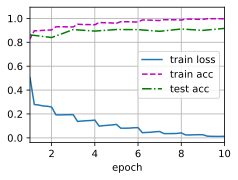

In [57]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(net, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())


### Exercises

1. What are the major differences between the Inception block in Fig. 7.4.1 and the residual
block? After removing some paths in the Inception block, how are they related to each other?
    - Inception uses multiple paths while resnet uses one single path with X.

2. Refer to Table 1 in the ResNet paper (He et al., 2016a) to implement different variants.
    - https://www.cv-foundation.org/openaccess/content_cvpr_2016/papers/He_Deep_Residual_Learning_CVPR_2016_paper.pdf
    
    -okay. Tried training resent 34

3. For deeper networks, ResNet introduces a “bottleneck” architecture to reduce model complexity. Try to implement it.

4. In subsequent versions of ResNet, the authors changed the “convolution, batch normalization, and activation” structure to the “batch normalization, activation, and convolution”
structure. Make this improvement yourself. See Figure 1 in (He et al., 2016b) for details.

5. Why canʼt we just increase the complexity of functions without bound, even if the function
classes are nested

In [61]:
# 2 
# implementing 34 layer resnet

b2 = nn.Sequential(*resnet_blk(64,64,3, first_block=True))
b3 = nn.Sequential(*resnet_blk(64, 128, 4))
b4 = nn.Sequential(*resnet_blk(128,256,6))
b5 = nn.Sequential(*resnet_blk(256,512,3))

resnet_34 = nn.Sequential(b1, b2, b3, b4, b5, nn.AdaptiveAvgPool2d((1,1)), nn.Flatten(), nn.Linear(512,10))

loss 0.033, train acc 0.988, test acc 0.826
325.3 examples/sec on cuda:0


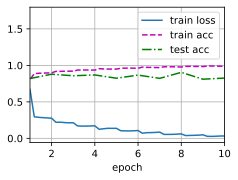

In [62]:
lr, num_epochs, batch_size = 0.05, 10, 256
train_iter, test_iter = load_data_fashion_mnist(batch_size, resize=96)
d2l.train_ch6(resnet_34, train_iter, test_iter, num_epochs, lr, d2l.try_gpu())
